# libraries

In [1]:
import librosa
#import librosa.display
import setuptools

from numpy.distutils.core import setup
%pylab inline --no-import-all
#from scikits.audiolab import wavread
from scipy import signal
import matplotlib.pyplot as plt
from scipy.io import wavfile
import math
import numpy as np
from numpy.fft import fft
import pylab
#import mir_eval
import seaborn
seaborn.set(style="ticks")

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from matplotlib import pyplot as pl
import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers.core import Dense, Dropout, Flatten
from keras.optimizers import RMSprop
from keras.utils import np_utils
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Input
from sklearn import metrics as me
from scipy import stats

%matplotlib inline

Using TensorFlow backend.


# functions

In [3]:
# load audio file function
def loadsingal(filename):
    signal ,sample_rate=librosa.load(filename,sr=12000, mono=True)
    signal=signal#[int(2.5 * sample_rate):int(3.0 * sample_rate)] 
    return signal ,sample_rate

In [4]:
# add silence in the end of audio file 
def comp_audio(data, fs, T):
    # Calculate target number of samples
    N_tar = int(fs * T)
    # Calculate number of zero samples to append
    shape = data.shape
    # Create the target shape    
    N_pad = N_tar - shape[0]
    # print("Padding with %s seconds of silence" % str(N_pad/fs) )
    shape = (N_pad,) + shape[1:]
    # Stack only if there is something to append    
    if shape[0] > 0:                
        if len(shape) > 1:
            return np.vstack((np.zeros(shape),
                              data))
        else:
            return np.hstack((np.zeros(shape),
                              data))
    else:
        return data

In [5]:
# convert audio in spectrogram
from scipy import signal
def spectrogram(signals,plot=False,sample_rate=12000):
    Sxxs=[]
    for i,data in enumerate(signals):
        f, t, Sxx = signal.spectrogram(data,sample_rate)
        Sxxs.append(Sxx)
       
        if plot==True:
            plt.pcolormesh(t, f, Sxx)
            plt.ylabel('Frequency [Hz]')
            plt.xlabel('Time [sec]')
            plt.grid()
            plt.show()
    return Sxxs

# Data loading

In [6]:
from sklearn.model_selection import train_test_split
import glob, os
dir ="/scratch/mlbd/"
dir ="/Users/kimtaing/Documents/github/MLBD/MLBD/birdsong/"
# changes current working directory
os.chdir(dir+"BECASSE_FILTREE")
filenames=[]
for file in glob.glob("*.wav"):
    filenames.append('/BECASSE_FILTREE/'+file)
    
# changes current working directory
os.chdir(dir+"NO_BECASSE_FILTREE")
filenames_N=[]
for file in glob.glob("*.wav"):
    filenames_N.append('NO_BECASSE_FILTREE/'+file)

nb_Files=10
filenames=filenames[:nb_Files]
filenames_N=filenames_N[:nb_Files]
signals=[]
signals_N=[]
time=float(30)

# load becasse audio file
for filename in filenames:
    path=dir +filename
    s ,sample_rate=loadsingal(path)
    #complete audio with fonction comp_audio to have commune size
    s_t=comp_audio(s,sample_rate,time)
    signals.append(s_t)
    
# load no_becasse audio file
for filename in filenames_N:
    path=dir +filename
    s_N ,sample_rate_N=loadsingal(path)
    s_N_t=comp_audio(s_N,sample_rate_N,time)
    signals_N.append(s_N_t)


# Data processing and preparation   

In [7]:
# load spectrogram of becase 
X_data_B=np.asarray(spectrogram(signals,False,sample_rate))
y_data_B=np.ones(len(X_data_B))  # 1:becasse, o: non becasse

# load spectrogram of non-becase 
data_inter=spectrogram(signals_N,False,sample_rate)

# delete error rows from "non becasse" sampling
rows_to_delete =[]
for i in range(len(data_inter)):
    if data_inter[i].shape[0] <> 129 or data_inter[i].shape[1] <> 1607:
        rows_to_delete.append(i)
        
for i,row in enumerate(rows_to_delete):
    del data_inter[row]   
        
# load spectrogram of non-becase final
X_data_N=np.asarray(data_inter)
y_data_N=np.zeros(len(X_data_N))  # 1:becasse, o: non becasse

# combine data "becasse" and "no becasse"
X_data = np.concatenate((X_data_B, X_data_N),axis=0)
y_data = np.concatenate((y_data_B ,y_data_N),axis=0)


In [8]:
# sampling data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
                        X_data, y_data, test_size=0.3, stratify=y_data)

print "X_train.shape : ", X_train.shape
print "y_train.shape : ", y_train.shape
print "X_test.shape : ", X_test.shape
print "y_test.shape : ", y_test.shape


n_train, height, width = X_train.shape
n_test, _, _ = X_test.shape

X_train = X_train.reshape(n_train, 1, height, width).astype('float32')
X_test = X_test.reshape(n_test, 1, height, width).astype('float32')

maxi_train_value=np.max(X_train[2])
maxi_test_value=np.max(X_test[2])


X_train /= float(maxi_train_value)
X_test /= float(maxi_test_value)

n_classes = 2

print n_train, 'train samples'
print n_test, 'test samples'

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

X_train.shape :  (14, 129, 1607)
y_train.shape :  (14,)
X_test.shape :  (6, 129, 1607)
y_test.shape :  (6,)
14 train samples
6 test samples


/Users/kimtaing/anaconda/lib/python2.7/site-packages/keras/utils/np_utils.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y[i, y[i]] = 1.


# Data modeling

In [19]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
def create_model(dropoutRate1=0.25,dropoutRate2=0.5,learningRate=0.0000000000000001):
    # create model
    model = Sequential()

    model.add(Convolution2D(9, 5, 5, activation='relu', input_shape=(1, height, width)))
    #model.add(Convolution2D(9, 5, 5, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(dropoutRate1))

    model.add(Flatten())
    #model.add(Dense(25, activation='relu'))
    model.add(Dropout(dropoutRate2))
    model.add(Dense(n_classes, activation='softmax'))
    model.summary()

    # Compile model
    keras.optimizers.RMSprop(lr=0.0000000000000001, rho=0.9, epsilon=1e-08, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

    return model

def create_model_MoreComplex(dropoutRate1=0.25,dropoutRate2=0.5,learningRate=0.0000000000000001):
    # create model
    model = Sequential()

    model.add(Convolution2D(9, 5, 5, activation='relu', input_shape=(1, height, width)))
    model.add(Convolution2D(9, 5, 5, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(dropoutRate1))

    model.add(Flatten())
    model.add(Dense(25, activation='relu'))
    model.add(Dropout(dropoutRate2))
    model.add(Dense(n_classes, activation='softmax'))
    model.summary()

    # Compile model
    
    keras.optimizers.RMSprop(lr=learningRate, rho=0.9, epsilon=1e-08, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

    return model

In [10]:
print X_train.shape
print Y_train.shape

print X_test.shape
print Y_test.shape


(14, 1, 129, 1607)
(14, 2)
(6, 1, 129, 1607)
(6, 2)


# Run models with def_create_model

In [13]:
from sklearn.metrics import precision_recall_fscore_support as score
# defin parameters 
learningRate=[0.0000000000000001,0.000000000000000000001]
dropoutRate1_tab=[0.10,0.25,0.5]
dropoutRate2_tab=[0.10,0.25,0.5]
batch_size_tab = [128,256]
n_epoch = 1

# result variables
test_score =[]
accuracy=[]
precisions=[]
recalls=[]
fscores=[]
supports=[]
params=[]

# run
for batch_size in batch_size_tab:
    for lr in learningRate:
        for dropoutRate1 in dropoutRate1_tab:
            for dropoutRate2 in dropoutRate2_tab:
                model=create_model(dropoutRate1,dropoutRate2,lr)
                history = model.fit(X_train, Y_train, batch_size=batch_size, 
                                nb_epoch=n_epoch, verbose=1, validation_data=(X_test, Y_test))
                
                # Prediction
                y_test_pred=model.predict_classes(X_test)
                
                # load parameter 
                param=str(batch_size)+"|"+str(lr)+"|"+str(dropoutRate1)+"|"+str(dropoutRate2)
                params.append(param)
                # test score & accuracy
                scores = model.evaluate(X_test, Y_test, verbose=0)
                test_score.append(scores[0])
                accuracy.append(scores[1])
                # precision, recall, fscore, support
                precision, recall, fscore, support = score(y_true=y_test, y_pred=y_test_pred)
                precisions.append(precision)
                recalls.append(recall)
                fscores.append(fscore)
                supports.append(support)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_34 (Convolution2D) (None, 9, 125, 1603)  234         convolution2d_input_34[0][0]     
____________________________________________________________________________________________________
maxpooling2d_34 (MaxPooling2D)   (None, 9, 62, 801)    0           convolution2d_34[0][0]           
____________________________________________________________________________________________________
dropout_67 (Dropout)             (None, 9, 62, 801)    0           maxpooling2d_34[0][0]            
____________________________________________________________________________________________________
flatten_34 (Flatten)             (None, 446958)        0           dropout_67[0][0]                 
___________________________________________________________________________________________

In [18]:
import sys
sys.stdout.write("{:<40}{:<10}{:<10}{:<15}{:<15}{:<15}{:<10}\n".format('Batch_size|lr|dropoutrate1|dropoutrate2','testScore','accuracy','precision','recall','fscores','support'))
for i,parm in enumerate(params):
    sys.stdout.write("{:<40}{:<10}{:<10}{:<15}{:<15}{:<15}{:<10}\n"
                     .format(parm
                             ,round(test_score[i],2)
                             ,round(accuracy[i],2)
                             ,str(round(precisions[i][0],2)) +' , '+str(round(precisions[i][1],2))
                             ,str(round(recalls[i][0],2)) +', '+str(round(recalls[i][1],2))
                             ,str(round(fscores[i][0],2)) +' , '+str(round(fscores[i][1],2))
                             ,supports[i][0]
                             )
                    )
   

Batch_size|lr|dropoutrate1|dropoutrate2 testScore accuracy  precision      recall         fscores        support   
128|1e-16|0.1|0.1                       0.63      0.67      1.0 , 0.6      0.33, 1.0      0.5 , 0.75     3         
128|1e-16|0.1|0.25                      0.65      0.67      1.0 , 0.6      0.33, 1.0      0.5 , 0.75     3         
128|1e-16|0.1|0.5                       0.65      0.5       0.0 , 0.5      0.0, 1.0       0.0 , 0.67     3         
128|1e-16|0.25|0.1                      0.61      0.67      1.0 , 0.6      0.33, 1.0      0.5 , 0.75     3         
128|1e-16|0.25|0.25                     0.63      0.67      1.0 , 0.6      0.33, 1.0      0.5 , 0.75     3         
128|1e-16|0.25|0.5                      0.64      0.67      1.0 , 0.6      0.33, 1.0      0.5 , 0.75     3         
128|1e-16|0.5|0.1                       0.63      0.67      1.0 , 0.6      0.33, 1.0      0.5 , 0.75     3         
128|1e-16|0.5|0.25                      0.62      0.67      1.0 , 0.6   

# Run models with create_model_MoreComplex

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score
# defin parameters 
learningRate=[0.0000000000000001,0.000000000000000000001]
dropoutRate1_tab=[0.10,0.25,0.5]
dropoutRate2_tab=[0.10,0.25,0.5]
batch_size_tab = [128,256]
n_epoch = 1

# result variables
test_score =[]
accuracy=[]
precisions=[]
recalls=[]
fscores=[]
supports=[]
params=[]

# run
for batch_size in batch_size_tab:
    for lr in learningRate:
        for dropoutRate1 in dropoutRate1_tab:
            for dropoutRate2 in dropoutRate2_tab:
                model=create_model_MoreComplex(dropoutRate1,dropoutRate2,lr)
                history = model.fit(X_train, Y_train, batch_size=batch_size, 
                                nb_epoch=n_epoch, verbose=1, validation_data=(X_test, Y_test))
                
                # Prediction
                y_test_pred=model.predict_classes(X_test)
                
                # load parameter 
                param=str(batch_size)+"|"+str(lr)+"|"+str(dropoutRate1)+"|"+str(dropoutRate2)
                params.append(param)
                # test score & accuracy
                scores = model.evaluate(X_test, Y_test, verbose=0)
                test_score.append(scores[0])
                accuracy.append(scores[1])
                # precision, recall, fscore, support
                precision, recall, fscore, support = score(y_true=y_test, y_pred=y_test_pred)
                precisions.append(precision)
                recalls.append(recall)
                fscores.append(fscore)
                supports.append(support)



In [ ]:
import sys
sys.stdout.write("{:<40}{:<10}{:<10}{:<10}{:<10}{:<15}{:<15}\n"
                 .format('Batch_size|lr|dropoutrate1|dropoutrate2'
                         ,'testScore','traiinScore'
                         ,'testAccuracy','trainAccuracy'
                         ,'testFscore','trainfscores'))
for i,parm in enumerate(params):
    sys.stdout.write("{:<40}{:<10}{:<10}{:<10}{:<10}{:<15}{:<15}\n"
                     .format(parm
                             ,round(test_score[i],2)
                             ,round(train_score[i],2)
                             ,round(accuracy[i],2)
                             ,round(train_accuracy[i],2)
                             ,str(round(fscores[i][0],2)) +' , '+str(round(fscores[i][1],2))
                             ,str(round(train_fscores[i][0],2)) +' , '+str(round(train_fscores[i][1],2))
                             )
                    )

In [ ]:
import sys
sys.stdout.write("{:<40}{:<10}{:<10}{:<15}{:<15}{:<15}{:<10}\n".format('Batch_size|lr|dropoutrate1|dropoutrate2','testScore','accuracy','precision','recall','fscores','support'))
for i,parm in enumerate(params):
    sys.stdout.write("{:<40}{:<10}{:<10}{:<15}{:<15}{:<15}{:<10}\n"
                     .format(parm
                             ,round(test_score[i],2)
                             ,round(accuracy[i],2)
                             ,str(round(precisions[i][0],2)) +' , '+str(round(precisions[i][1],2))
                             ,str(round(recalls[i][0],2)) +', '+str(round(recalls[i][1],2))
                             ,str(round(fscores[i][0],2)) +' , '+str(round(fscores[i][1],2))
                             ,supports[i][0]
                             )
                    )
   

# Display best results

In [ ]:
# re-run model with parameters giving the best result
dropoutRate1=0.25
dropoutRate2=0.25
learningRate=0.0000000000000001
batch_size=128
n_epoch=2
# choix between def create_model or create_model_MoreComplex
model=create_model(dropoutRate1,dropoutRate2,learningRate)  
history = model.fit(X_train, Y_train, batch_size=batch_size, 
                nb_epoch=n_epoch, verbose=1, validation_data=(X_test, Y_test))

# Prediction
y_test_pred=model.predict_classes(X_test)

('Train score:', 0.22404609620571136)
('Train accuracy:', 1.0)
('Test score:', 0.44794106483459473)
('Test accuracy:', 1.0)


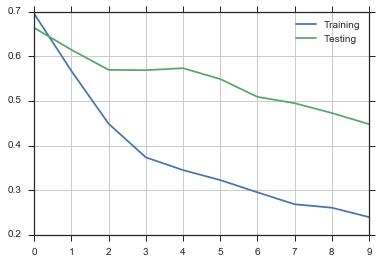

In [25]:
# Test score & accuracy
pl.plot(history.history['loss'], label='Training')
pl.plot(history.history['val_loss'], label='Testing')
pl.legend()
pl.grid()

score = model.evaluate(X_train, Y_train, verbose=0)
print('Train score:', score[0])
print('Train accuracy:', score[1])

score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

In [26]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



Confusion matrix, without normalization
[[3 0]
 [0 3]]
Normalized confusion matrix
[[ 1.  0.]
 [ 0.  1.]]


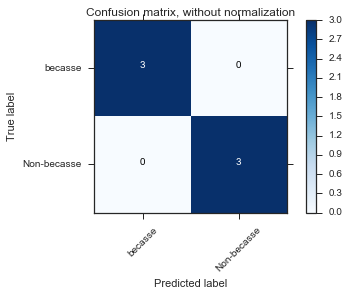

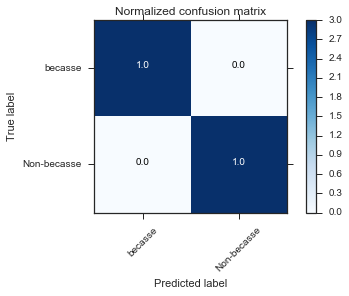

In [102]:
# Display confuson matrix
import sklearn.metrics as skmetrics

class_names=['becasse', 'Non-becasse']
cnf_matrix = skmetrics.confusion_matrix(y_true=y_test, y_pred=y_test_pred)

# Plot non-normalized confusion matrix
print "\n"
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

In [104]:
# Display different evaluating criteria 
print skmetrics.classification_report(y_true=y_test, y_pred=y_test_pred,target_names=class_names)


             precision    recall  f1-score   support

    becasse       1.00      1.00      1.00         3
Non-becasse       1.00      1.00      1.00         3

avg / total       1.00      1.00      1.00         6



In [66]:
'''
from sklearn.metrics import f1_score
# Precision of the positive class in binary classification or weighted average of the precision of each class for the multiclass task.
from sklearn.metrics import precision_score 
f1_score =f1_score(y_true=y_test, y_pred=y_test_pred)
precision_score =precision_score(y_true=y_test, y_pred=y_test_pred)


batch_size = 128
n_epoch = 10
model=create_model()
history = model.fit(X_train, Y_train, batch_size=batch_size, 
                    nb_epoch=n_epoch, verbose=1, validation_data=(X_test, Y_test))
                    

learningRate=0.0000000000000001
dropoutRate1=0.25
dropoutRate2=0.5
batch_size_Tab = [128,256]
n_epoch = 2
test_score =[]
accuracy=[]
precisions=[]
recalls=[]
fscores=[]
supports=[]
params=[]
for batch_size in (batch_size_Tab):
    # Training
    model=create_model(dropoutRate1,dropoutRate2,learningRate)
    history = model.fit(X_train, Y_train, batch_size=batch_size, 
                                nb_epoch=n_epoch, verbose=1, validation_data=(X_test, Y_test))
    # Prediction
    param=str(batch_size)+"-"+str(learningRate)
    params.append(param)
    scores = model.evaluate(X_test, Y_test, verbose=0)
    test_score.append(scores[0])
    accuracy.append(scores[1])
    
    precision, recall, fscore, support = score(y_true=y_test, y_pred=y_test_pred)
    precisions.append(precision)
    recalls.append(recall)
    fscores.append(fscore)
    supports.append(support)
'''


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_13 (Convolution2D) (None, 9, 125, 1603)  234         convolution2d_input_13[0][0]     
____________________________________________________________________________________________________
maxpooling2d_13 (MaxPooling2D)   (None, 9, 62, 801)    0           convolution2d_13[0][0]           
____________________________________________________________________________________________________
dropout_25 (Dropout)             (None, 9, 62, 801)    0           maxpooling2d_13[0][0]            
____________________________________________________________________________________________________
flatten_13 (Flatten)             (None, 446958)        0           dropout_25[0][0]                 
___________________________________________________________________________________________